In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from dateutil.relativedelta import relativedelta

import scipy.stats as scs
# from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error

# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые


from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

import statsmodels


import gc
import glob
import os

# sns.set()
%matplotlib inline

# import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

# DISPLAY_MAX_ROWS = 20 #20
# pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
# pd.set_option('display.max_column', 100) # None)
# plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_files = glob.glob(os.path.join("/content/drive/MyDrive/Colab Notebooks/k8s/cpu/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, skiprows=[0], parse_dates=['Time'])
    li.append(df)


cpu = pd.concat(li, axis=0, ignore_index=True)

fields_nodes_all = ['real: cl1i6ek5us1gmcv87dql-oqaz |  ', 'real: cl1i6ek5us1gmcv87dql-ulyg |  ', 'real: cl1i6ek5us1gmcv87dql-utuc |  ']
fields_nodes_first = ['Time', 'real: cl1i6ek5us1gmcv87dql-oqaz |  ']

cpu.columns = ['Time', 'node1', 'node2', 'node3']
cpu['nodes_all'] = cpu['node1'] + cpu['node2'] + cpu['node3']


In [ ]:
cpu

,Time,node1,node2,node3,nodes_all
0,2023-10-15 19:10:00,0.723,0.174,0.490,1.387
1,2023-10-15 19:15:00,1.650,0.953,0.492,3.095
2,2023-10-15 19:20:00,1.390,0.824,0.378,2.592
3,2023-10-15 19:25:00,1.400,0.734,0.473,2.607
4,2023-10-15 19:30:00,1.490,0.879,0.528,2.897
...,...,...,...,...,...
1493,2023-10-20 23:35:00,0.551,0.813,0.632,1.996
1494,2023-10-20 23:40:00,0.508,0.777,0.641,1.926
1495,2023-10-20 23:45:00,0.506,0.912,0.735,2.153
1496,2023-10-20 23:50:00,0.509,0.841,0.636,1.986


In [ ]:
cpu_all = cpu[['Time', 'nodes_all']]
cpu_all.set_index('Time', inplace=True)

cpu_all = cpu_all.resample('1H', base=0.5).last()


print(cpu_all.isnull().any())
print(cpu_all.isna().any())
cpu_all['nodes_all'].fillna(cpu_all['nodes_all'].mean(), inplace=True)

nodes_all    False
dtype: bool
nodes_all    False
dtype: bool


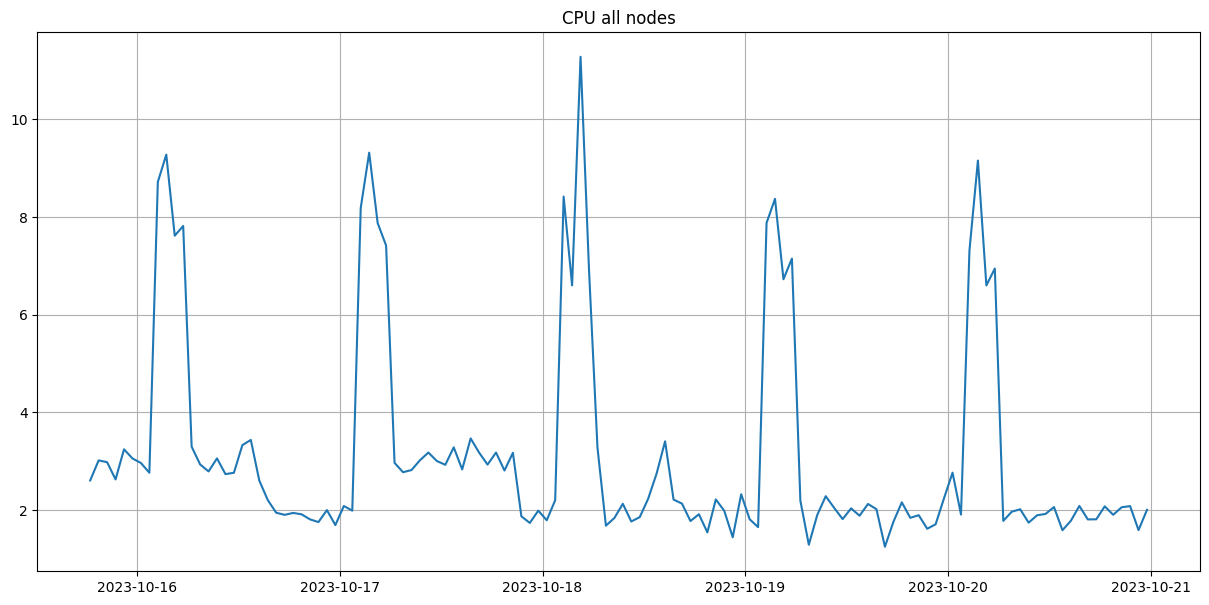

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(cpu_all.nodes_all)
plt.title('CPU all nodes')
plt.grid(True)
plt.show()

In [ ]:
def plotMovingAverage(series, window, plot_intervals=True, scale=1.96, plot_anomalies=True):

    """
        series - фрейм данных с временными рядами
        window - скользящий размер окна
        plot_intervals - показывает доверительные интервалы
        plot_anomalies - показывает аномалии

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Построение доверительных интервалов для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Имея интервалы, найдем аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

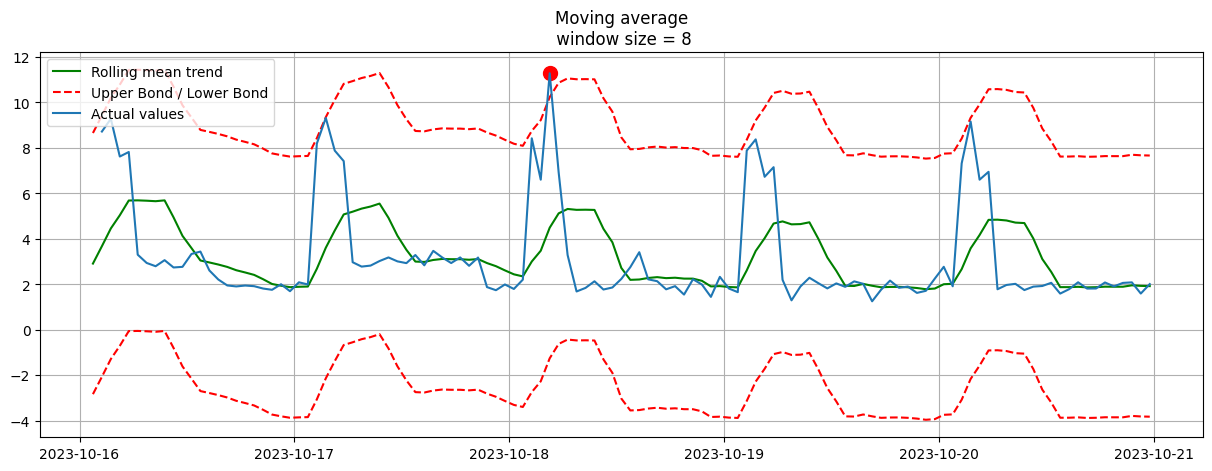

In [ ]:
plotMovingAverage(cpu_all, 8)

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - набор данных с временными метками
        alpha - значение с плавающей точкой [0.0, 1.0], параметр сглаживания
    """
    result = [series[0]] # первое значение совпадает с рядом
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Строит графики экспоненциального сглаживания с различными alpha
        series - набор данных с временными метками
        alphas - список значений с плавающей точкой, параметры сглаживания
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

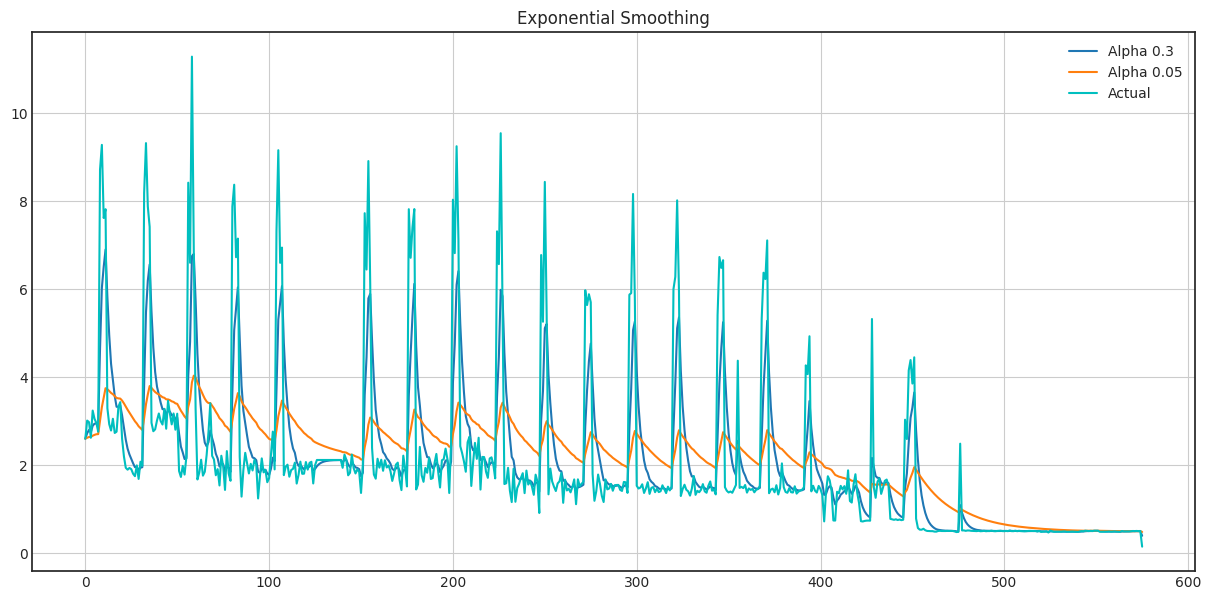

In [ ]:
plotExponentialSmoothing(cpu_all.nodes_all, [0.3, 0.05])

In [ ]:
!pip install sktime
from sktime.utils.plotting import plot_series

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 16.7 MB/s eta 0:00:00


<Figure size 1500x600 with 0 Axes>

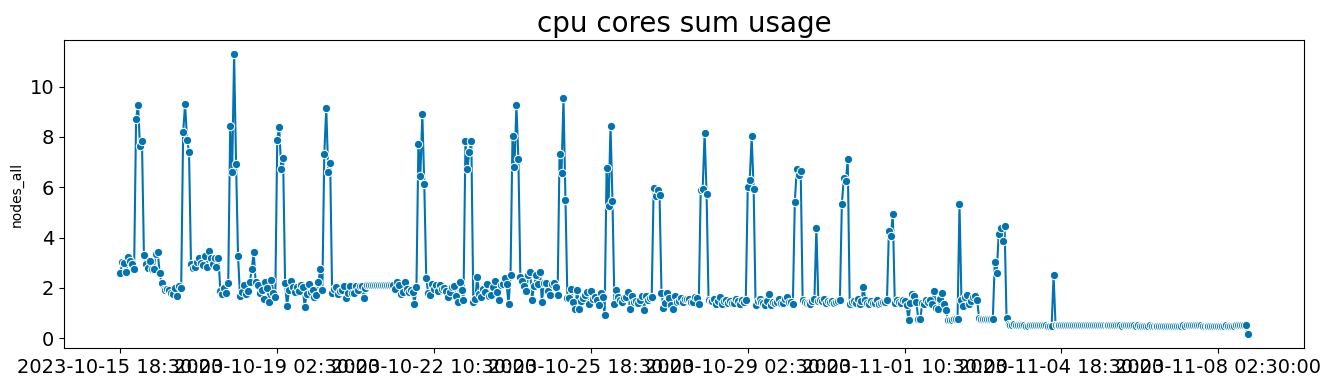

In [ ]:
from sktime.utils.plotting import plot_series

plt.figure(figsize=(15, 6))
y = cpu_all.nodes_all#/10**3
plot_series (y)
plt.title('cpu cores sum usage', fontsize=20, color='black')
plt.tick_params(axis = 'both', which ='major', labelsize = 14);

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(cpu_all.nodes_all)
print('p-value = ' + str(adf_test[1]))

p-value = 7.378643608047714e-07
